In [ ]:
#generalizability thoughts:
#    filename differences - biom/fasta ID, sample info prep number

In [2]:
import os
import pandas as pd
import seaborn as sns
import shutil
import tempfile

from IPython.core.display import display

from qiime2 import Artifact
from qiime2.metadata import Metadata
from qiime2.plugins.feature_classifier.methods import classify_consensus_vsearch
from qiime2.plugins.feature_table.methods import filter_samples, filter_seqs, relative_frequency
from qiime2.plugins.feature_table.visualizers import summarize
from qiime2.plugins.taxa.visualizers import barplot
from qiime2 import Visualization

from scipy import stats

%matplotlib inline
working_dir = os.path.abspath('../')
refs_dir = working_dir + '/output/taxonomy_references'

In [2]:
seqs = Artifact.import_data('FeatureData[Sequence]', working_dir + '/input/61139_all.seqs.fa')
seqs.save(working_dir + '/output/smp_sequences.qza')

'/mnt/c/Users/Dylan/Documents/zaneveld/smp/output/smp_sequences.qza'

In [18]:
#edit metadata from qiita to be compatible with qiime2
with open(working_dir + '/input/sample_information_from_prep_1257.tsv', 'r+') as tsvfile:
    lines = tsvfile.readlines()
    #sample_id is not a valid label, must be changed
    headers = lines[0].split('\t', 1)
    headers[0] = 'sample-id'
    lines[0] = '\t'.join(headers)
    tsvfile.seek(0)
    tsvfile.writelines(lines)
metadata = Metadata.load(working_dir + '/input/sample_information_from_prep_1257.tsv')

In [34]:
#split and/or filter the feature table
ft = Artifact.import_data('FeatureTable[Frequency]', working_dir + '/input/61139_all.biom', 'BIOMV210Format')
ft, = filter_samples(ft, metadata = metadata, where = "empo_2 = 'Animal'")
ft.save(working_dir + '/output/smp_ft.qza')
#compartments = ['M', 'T', 'S']
#for compartment in compartments:
#     where = "tissue_compartment='" + compartment + "'"
#     GCMP_filtered, = filter_samples(GCMP_ft, metadata = metadata,
#                                    where = where)
#     save_path = working_dir + '/output/' + compartment + "_ft.qza"
#     GCMP_filtered.save(save_path)

'/mnt/c/Users/Dylan/Documents/zaneveld/smp/output/smp_ft.qza'

In [35]:
silva_seqs = Artifact.load(refs_dir + '/silva-138-99-seqs-515-806.qza')
silva_taxonomy = Artifact.load(refs_dir + '/silva-138-99-tax-515-806.qza')
extended_seqs = Artifact.load(refs_dir + '/extended_sequences.qza')
extended_taxonomy = Artifact.load(refs_dir + '/extended_taxonomy.qza')
ft = Artifact.load(working_dir + '/output/smp_ft.qza')
seqs = Artifact.load(working_dir + '/output/smp_sequences.qza')
silva_classification_taxonomy, = classify_consensus_vsearch(seqs, silva_seqs,
                                                            silva_taxonomy,
                                                            threads = 24)
silva_classification_taxonomy.save(working_dir + '/output/silva_classification_taxonomy.qza')
extended_classification_taxonomy, = classify_consensus_vsearch(seqs,
                                                               extended_seqs,
                                                               extended_taxonomy,
                                                               threads = 24)
extended_classification_taxonomy.save(working_dir + '/output/extended_classification_taxonomy.qza')

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-4qsbv44d/390d5f8a-603b-46c1-9d15-0d89f6f7ba91/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --db /tmp/qiime2-archive-rxo_h2q_/b41681fb-a4e7-4ef8-a23a-a26f1bcfd272/data/dna-sequences.fasta --threads 24 --output_no_hits --blast6out /tmp/tmptbp6a9lq

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-4qsbv44d/390d5f8a-603b-46c1-9d15-0d89f6f7ba91/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --db /tm

'/mnt/c/Users/Dylan/Documents/zaneveld/smp/output/extended_classification_taxonomy.qza'

In [36]:
#tbp takes much longer the more metadata is included. to reduce calculation
#time, we use the minimum metadata (sample names only) while and merge the rest
#of the metadata later
references = ['silva', 'extended']
md_q2 = Metadata.load(working_dir + '/input/sample_information_from_prep_1257.tsv')
md_df = md_q2.to_dataframe()
md_df.drop(md_df.columns.difference(['sample-id']), 1, inplace = True)
md_q2 = Metadata(md_df)
for reference in references:
    taxonomy_path = working_dir + '/output/' + reference + '_classification_taxonomy.qza'
    taxonomy = Artifact.load(taxonomy_path)
    tbp, = barplot(ft, taxonomy, md_q2)
    tbp.save(working_dir + '/output/' + reference + '_tbp.qzv')

In [37]:
ft = Artifact.load(working_dir + '/output/smp_ft.qza')
ft, = filter_samples(ft, metadata = md_q2)


In [50]:
results = pd.DataFrame(columns = ['proportion unassigned',
                                  'proportion chloroplasts',
                                  'proportion mitochondria',
                                  'reference taxonomy']).rename_axis('sample-id')
with tempfile.TemporaryDirectory() as temp_dir:
    for reference in ['silva', 'extended']:
        reference_results = pd.DataFrame().rename_axis('sample-id')
        qzv = Visualization.load(working_dir + '/output/' + reference + '_tbp.qzv')
        qzv.export_data(temp_dir)
        df1 = pd.read_csv(temp_dir + '/level-1.csv',
                          index_col = 0).rename_axis('sample-id')
        df1['total'] = df1.iloc[:, 0:4].sum(1)
        df1['proportion unassigned'] = df1['Unassigned'] / df1['total']
        reference_results['proportion unassigned'] = df1['proportion unassigned']
        df4 = pd.read_csv(temp_dir + '/level-4.csv',
                          index_col = 0).rename_axis('sample-id')
        df4['total'] = df4.iloc[:, 0:540].sum(1)
        df4['proportion chloroplasts'] = df4['d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Chloroplast'] / df4['total']
        reference_results['proportion chloroplasts'] = df4['proportion chloroplasts']
        df5 = pd.read_csv(temp_dir + '/level-5.csv',
                          index_col = 0).rename_axis('sample-id')
        df5['total'] = df5.iloc[:, 0:934].sum(1)
        df5['proportion mitochondria'] = df5['d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__Mitochondria'] / df5['total']
        reference_results['proportion mitochondria'] = df5['proportion mitochondria']
        reference_results['reference taxonomy'] = reference
        reference_results.set_index(df1.index)
        results = results.append(reference_results)
md = pd.read_csv(working_dir + '/input/sample_information_from_prep_1257.tsv',
                 '\t', index_col = 0)
results_with_metadata = results.merge(md, 'left', left_index = True,
                                      right_index = True)
results_with_metadata.to_csv(working_dir + '/output/proportions.csv')

In [51]:
df = pd.read_csv((working_dir + '/output/proportions.csv'), index_col = 0)
silva = df['proportion unassigned'][(df['reference taxonomy'] == 'silva')]
extended = df['proportion unassigned'][(df['reference taxonomy'] == 'extended')]
H, p = stats.kruskal(silva, extended)
print(H, p)

158.86982553711564 1.9979432793641177e-36


/home/dylan/miniconda3/envs/qiime2-2021.2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 30.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dylan/miniconda3/envs/qiime2-2021.2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 50.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


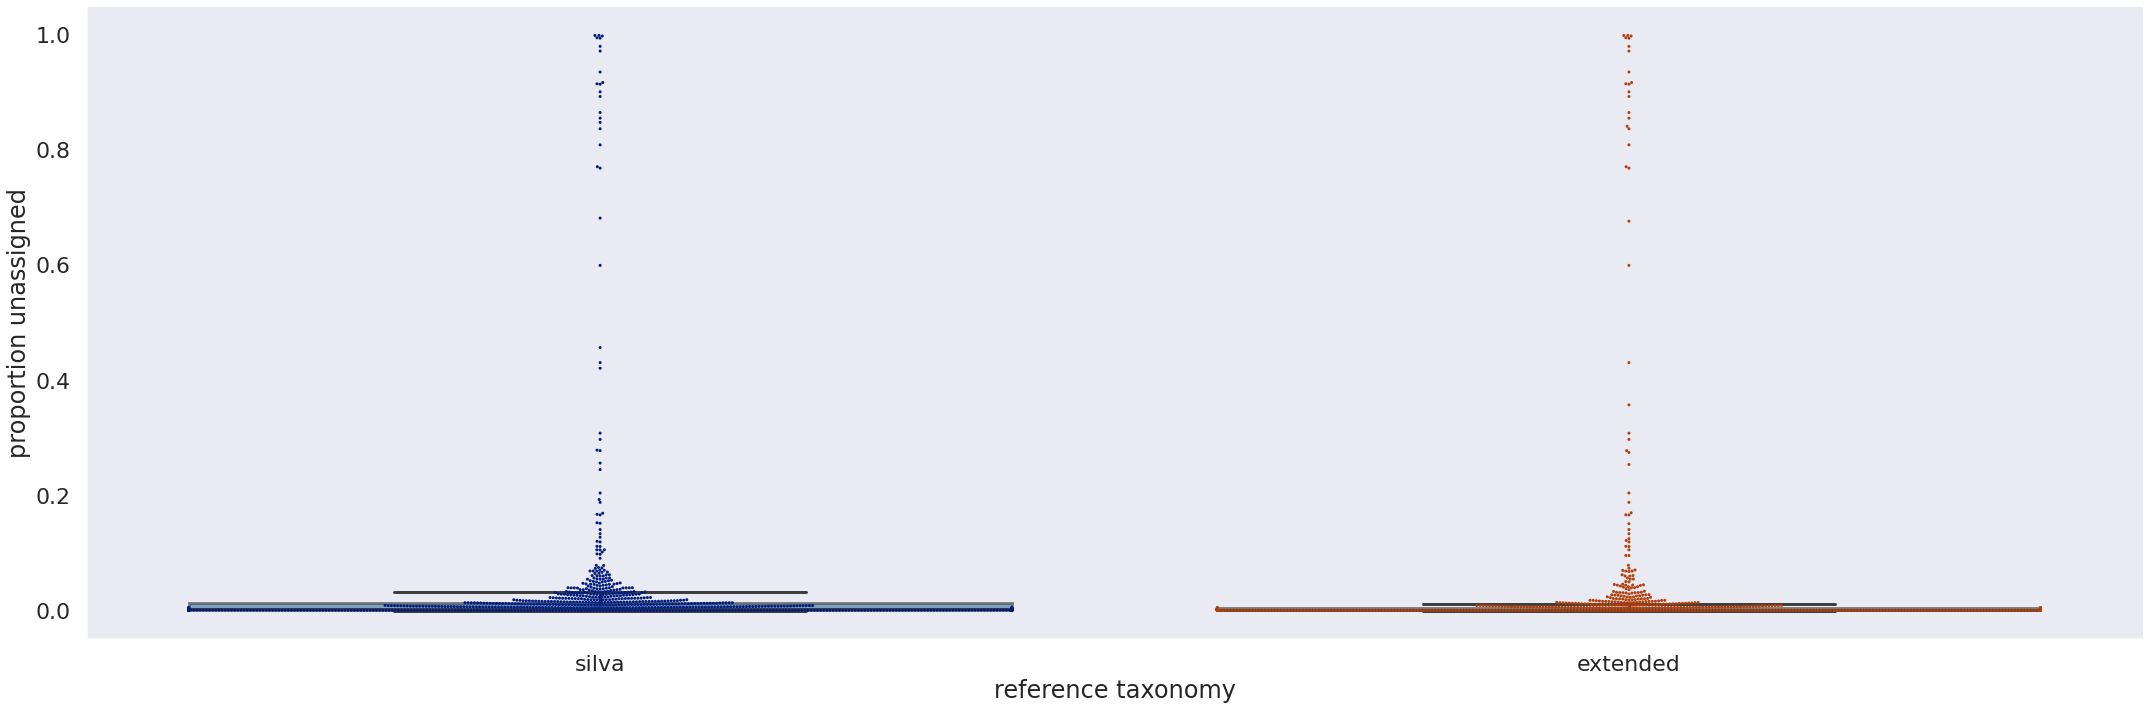

In [52]:
sns.set_style("dark")
sns.set_context("poster")

g = sns.catplot(boxprops = dict(alpha = .6), height = 10, aspect = 3,
                x = "reference taxonomy", y = "proportion unassigned",
                kind = "box", data = df,
                fliersize = 0)
h = sns.swarmplot(x = "reference taxonomy", y = "proportion unassigned",
                  dodge = True, size = 3, data = df, ax = g.ax,
                  palette = "dark")

In [53]:
silva = df['proportion chloroplasts'][(df['reference taxonomy'] == 'silva')]
extended = df['proportion chloroplasts'][(df['reference taxonomy'] == 'extended')]
H, p = stats.kruskal(silva, extended)
print(H, p)

0.030340680667300696 0.8617194725458953


/home/dylan/miniconda3/envs/qiime2-2021.2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 48.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dylan/miniconda3/envs/qiime2-2021.2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 47.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


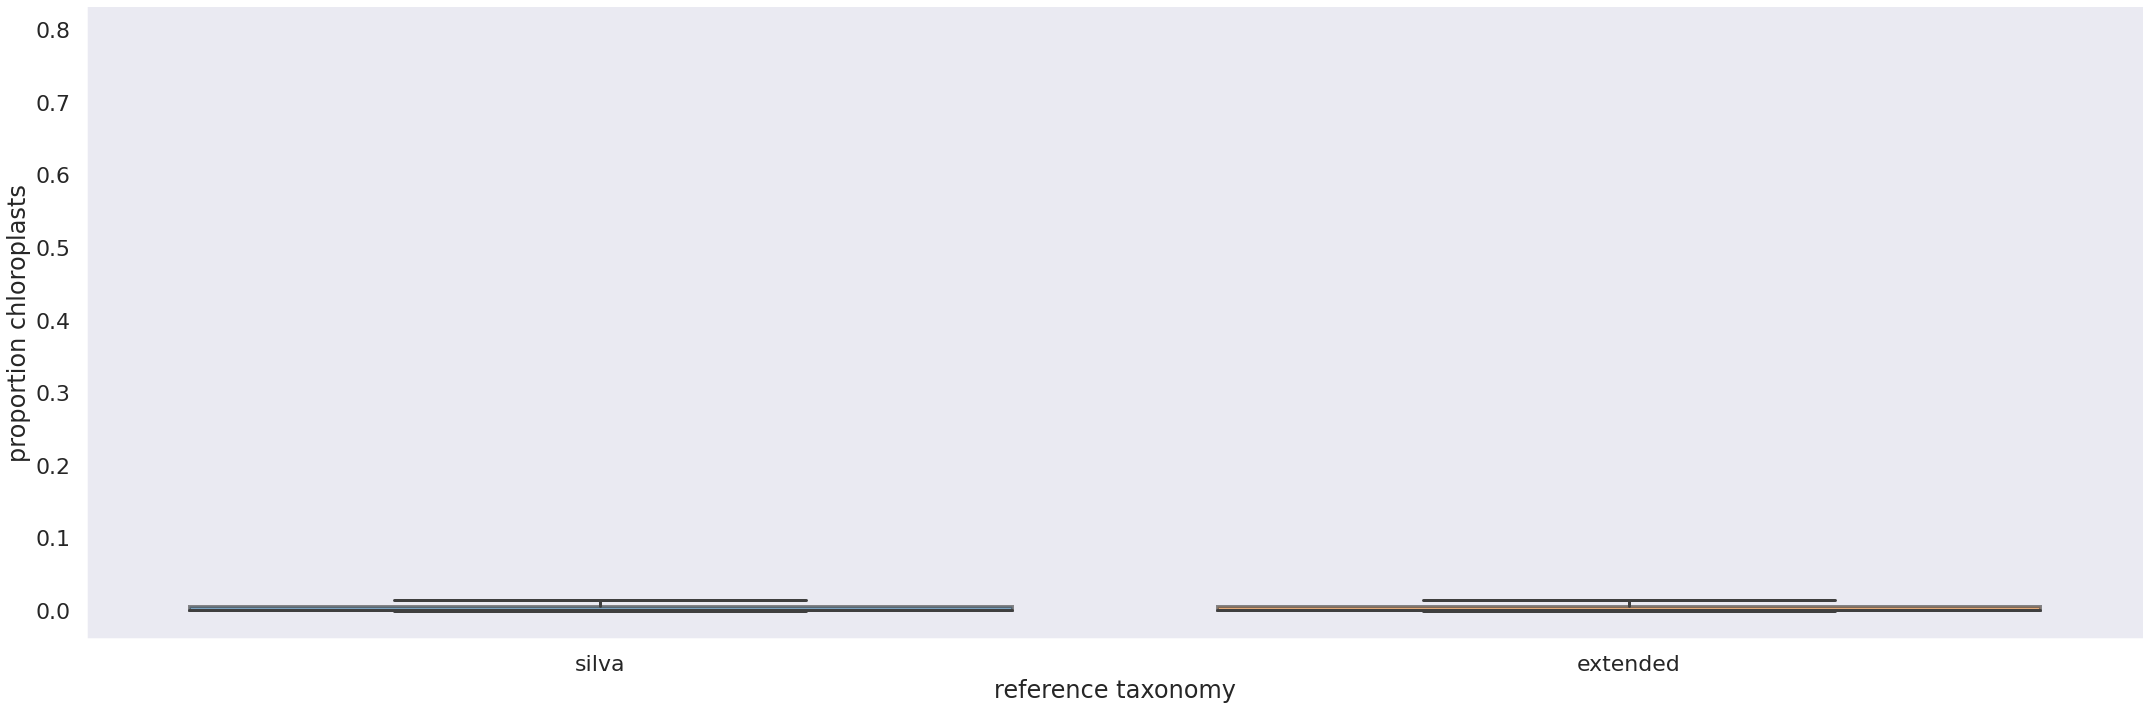

In [54]:
i = sns.catplot(boxprops = dict(alpha = .6), height = 10, aspect = 3,
                x = "reference taxonomy", y = "proportion chloroplasts",
                kind = "box", data = df,
                fliersize = 0)
j = sns.swarmplot(x = "reference taxonomy", y = "proportion chloroplasts",
                  dodge = True, size = 3, data = df, ax = g.ax,
                  palette = "dark")

In [55]:
silva = df['proportion mitochondria'][(df['reference taxonomy'] == 'silva')]
extended = df['proportion mitochondria'][(df['reference taxonomy'] == 'extended')]
H, p = stats.kruskal(silva, extended)
print(H, p)

706.124475965418 1.3928515357070611e-155


/home/dylan/miniconda3/envs/qiime2-2021.2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 71.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dylan/miniconda3/envs/qiime2-2021.2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 36.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


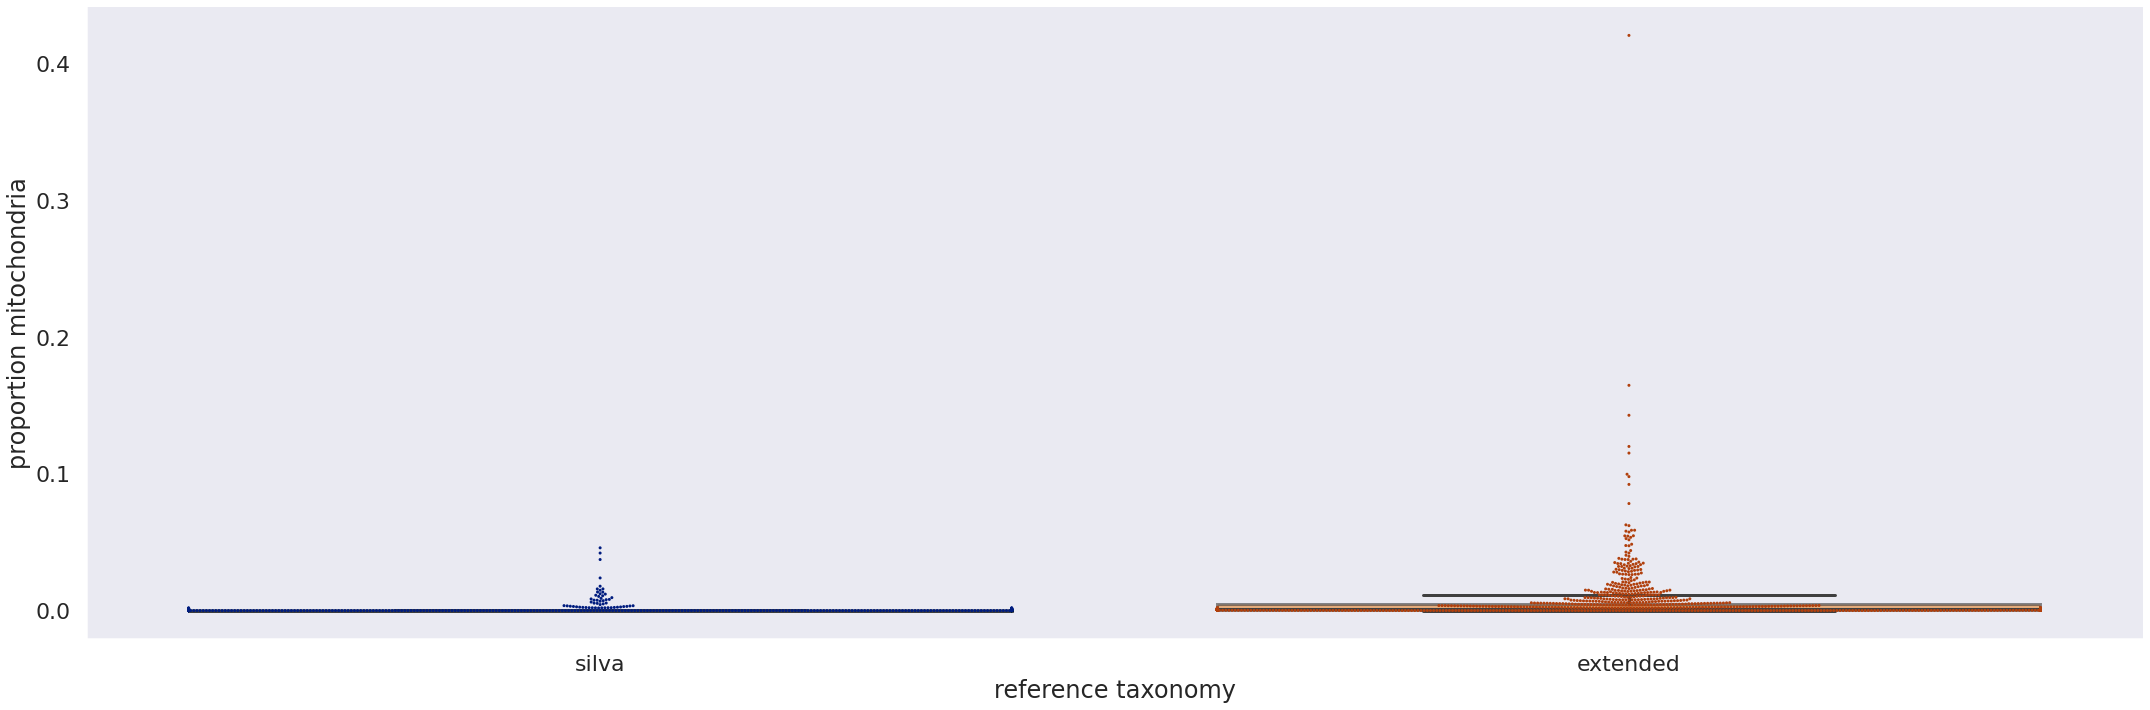

In [56]:
k = sns.catplot(boxprops = dict(alpha = .6), height = 10, aspect = 3,
                x = "reference taxonomy", y = "proportion mitochondria",
                kind = "box", data = df, fliersize = 0)
l = sns.swarmplot(x = "reference taxonomy", y = "proportion mitochondria",
                  dodge = True, size = 3, data = df, ax = k.ax,
                  palette = "dark")

In [59]:
#find differentially annotated sequences
silva_classification = Artifact.load(working_dir +
                                     '/output/silva_classification_taxonomy.qza')
extended_classification = Artifact.load(working_dir +
                                     '/output/extended_classification_taxonomy.qza')
with tempfile.TemporaryDirectory() as temp_dir:
    silva_classification.export_data(temp_dir)
    silva_taxonomy = pd.read_csv(temp_dir + '/taxonomy.tsv', '\t')
    extended_classification.export_data(temp_dir)
    extended_taxonomy = pd.read_csv(temp_dir + '/taxonomy.tsv', '\t')
silva_taxonomy = silva_taxonomy.sort_values('Feature ID')
silva_taxonomy = silva_taxonomy.reset_index()
silva_taxonomy = silva_taxonomy.drop(['Consensus','index'],1)
extended_taxonomy = extended_taxonomy.sort_values('Feature ID')
extended_taxonomy = extended_taxonomy.reset_index()
extended_taxonomy = extended_taxonomy.drop(['Consensus','index'],1)
results = silva_taxonomy.compare(extended_taxonomy)
results.columns = ['silva', 'extended']
results['sequence'] = silva_taxonomy['Feature ID']
with open(working_dir + '/output/differential_annotations.fasta', 'w') as fasta_file:
    for row in results.itertuples(False, None):
        fasta_file.write('>' + row[0] + '|' + row[1] + '\n' + row[2] + '\n')
with open(working_dir + '/output/differential_annotations.tsv', 'w') as tsv:
    tsv.write('sequence\tsilva_annotation\textended_annotation\n')
    for row in results.itertuples(False, None):
        tsv.write(row[2] + '\t' + row[0] + '\t' + row[1] + '\n')

In [71]:
import ftplib

<bound method FTP.quit of <ftplib.FTP object at 0x7fdec75ee668>>

In [64]:
import glob
import tarfile
for path in glob.glob(working_dir + '/input/*.tar.gz'):
    tar = tarfile.open(path, 'r:gz')
    tar.extractall()
    tar.close

EOFError: Compressed file ended before the end-of-stream marker was reached

In [65]:
path

'/mnt/c/Users/Dylan/Documents/zaneveld/smp/input/nr.00.tar.gz'